In [10]:
import networkx as nx
import json
import heapq
import sqlite3
import pandas as pd
import ast
import matplotlib.pyplot as plt
import sys
sys.path.append("..")
from helpers import reformat, printGraph, json_to_kg
import sys
sys.path.append("..")
from PatientGraph import query_kg, get_trajectory


ImportError: cannot import name 'get_trajectory'

In [2]:
graph_file = "kg_results/full_kg_pruned.json"
kg = json_to_kg(graph_file)

In [3]:
# Opens saved sample conversation data
con = sqlite3.connect("/collab/rice_capstone/wlu5/rasa-analysis/conversation.db")
conversation_data = pd.read_sql_query("SELECT * FROM patient_profile", con)
con.close()
# Modify conversation data a bit
conversation_data = conversation_data.replace(to_replace=['["nose", "coughing", "headache"]'], value = '["nose", "coughing"]')
conversation_data

,index,patient_id,session_id,symptoms,drugs
0,0,ba5ea0d21d854bf2afac4d5a04da02d8,1,,"[""hydroxychloroquine""]"
1,1,0484a965229040df9f52773164618f10,1,,"[""hydroxychloroquine""]"
2,2,d015f1c7f87242759ca601080f01b56a,1,"[""headache""]",
3,3,fecdd55d02554b0c9d7f4960e9213c7b,1,"[""headache""]",
4,4,5223fe5b8d4143e894e7d9142e674940,1,"[""headache""]",
5,5,42613706c7444af4ac33a316d0dcc2a8,1,"[""headache""]",
6,6,42613706c7444af4ac33a316d0dcc2a8,2,"[""nose"", ""coughing""]",
7,7,e65db7bea39841c49ed801cc97de8d87,1,"[""headache""]",


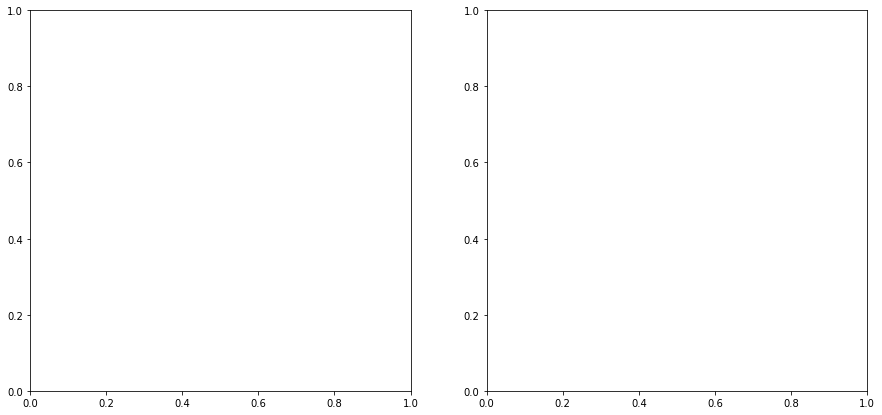

In [4]:
conversation_data['predictions'] = conversation_data.apply(lambda row: query_kg(kg, row['patient_id'], row['symptoms'], row['drugs'], 5), axis = 1)
predictions = conversation_data['predictions'].to_list()
symptoms = conversation_data['symptoms'].to_list()
drugs = conversation_data['drugs'].to_list()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,7))
c = 0
patient_id_trajectory = get_trajectory()
# Display color-coded graph for each patient in the patient trajectory
for patient_id, predictions_over_time in patient_id_trajectory.items():
    for i in range(len(predictions_over_time)):
        prediction = predictions_over_time[i]
        print ("------" + str(patient_id) + "------")
        print (prediction)
        predict_nodes = [val[2] for val in prediction]
        root_nodes = [val[1] for val in prediction]
        combined = set(predict_nodes + root_nodes)
        H = kg.subgraph(combined)
        
        # Color-code patient subgraph nodes versus preexisting knowledge graph nodes
        node_colors = []
        for node in H:
            if node in root_nodes:
                node_colors.append('#FFA07A')
            else:
                node_colors.append('#A0CBE2')

        # Thicken edges with higher weights
        edge_colors = []
        for (u, v, wt) in H.edges.data('weight'):
            if (wt, u, v) in prediction or (wt, v, u) in prediction:
                print(f"({u}, {v}, {wt})")
                edge_colors.append(wt)
            else:
                edge_colors.append(0)

        pos = nx.spring_layout(H)
        #colors = range(len(H.edges))
        options = {
            "node_color": node_colors,
            "edge_color": edge_colors,
            "width": 4,
            "edge_cmap": plt.cm.Blues,
            "with_labels": True,
        }
        nx.draw(H, pos, **options, ax=axes[c])
        c += 1
